In [105]:
import gymnasium as gym
import gym_donkeycar

import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.distributions import Normal

import torchvision
from torchvision import transforms

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
# Preprocessing

""" transformation: scale pixel values and resize the shape """
transform = transforms.Compose([
    transforms.ToTensor(), # -> scaled to [0,1]
    transforms.Lambda(lambda x: x.to(device)), # Move to device
    transforms.Resize((128, 128)), # 3x128x128,
    transforms.Grayscale(),
])

In [71]:
# self.dropout = nn.Dropout2d(dropout_rate)

In [111]:
class ConvBlock(nn.Module):
    """ Use this block to change the number of channels. """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

class TransposeConvBlock(nn.Module):
    """ Use this block to change the number of channels and perform a deconvolution
        followed by batchnorm and a relu activation. """
    def __init__(self, in_channels, out_channels):
        super(TransposeConvBlock, self).__init__()
        
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.deconv(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

class ResConvBlock(nn.Module):
    """ This block needs the same number input and output channels.
        It performs three convolutions with batchnorm, relu 
        and then adds a skip connection. """
    def __init__(self, in_channels, out_channels):
        super(ResConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        
        x = self.conv2(x)        
        x += residual
        x = self.relu(x)
        x = self.bn2(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, greyscale=True):
        super(Autoencoder, self).__init__()

        if greyscale:
            self.input_channels = 1
        else:
            self.input_channels = 3
        
        self.encoder = nn.Sequential(
            ConvBlock(self.input_channels, 16),
            ResConvBlock(16, 16),
            nn.Conv2d(16, 16, kernel_size=4, padding=1, stride=2), #nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(16, 32),
            ResConvBlock(32, 32),
            nn.Conv2d(32, 32, kernel_size=4, padding=1, stride=2), #nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(32, 64),
            ResConvBlock(64, 64),
            nn.Conv2d(64, 64, kernel_size=4, padding=1, stride=2), #nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(64, 128),
            ResConvBlock(128, 128),
            nn.Conv2d(128, 128, kernel_size=4, padding=1, stride=2), #nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(128, 256),
            ResConvBlock(256, 256),
            nn.Conv2d(256, 256, kernel_size=4, padding=2, stride=2), #nn.MaxPool2d(kernel_size=2, stride=2),
            
            ResConvBlock(256, 256),
            ConvBlock(256, 2),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=2),
            TransposeConvBlock(16, 32),
            ResConvBlock(32, 32),
            
            TransposeConvBlock(32, 64),
            ResConvBlock(64, 64),
            
            TransposeConvBlock(64, 128),
            ResConvBlock(128, 128),
            
            TransposeConvBlock(128, 256),
            ResConvBlock(256, 256),
            
            TransposeConvBlock(256, 512),
            ResConvBlock(512, 512),
            
            ResConvBlock(512, 512),
            ConvBlock(512, 32),
            nn.Conv2d(32, self.input_channels, kernel_size=3, padding=1, stride=1),
            nn.Sigmoid()
        )

        
    def encode(self, x):
        z = self.encoder(x)
        return z
    
    def decode(self, z):
        x = self.decoder(z)
        return x
        
    def forward(self, x):
        z = self.encode(x)
        x = self.decode(z)
        return x

    def get_loss(self, x, xhat):
        return F.mse_loss(xhat, x)

    def save_weights(self):
        if not os.path.exists("weights"):
            os.mkdir("weights")
        torch.save(self.state_dict(), "weights/AE")
    
    def load_weights(self, path="weights/AE", eval_mode=True):
        self.load_state_dict(torch.load(path))
        if eval_mode:
            print("Set AE to evaluation mode.")
            self.eval()
        
    def get_num_params(self):
        return sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)

autoencoder = Autoencoder(greyscale=True).to(device)
autoencoder_criterion = nn.MSELoss()

autoencoder_optim = optim.Adam(
    autoencoder.parameters(), 
    lr=3e-4, 
    weight_decay=1e-5 # l2 regularization
)

autoencoder_scheduler = ReduceLROnPlateau(autoencoder_optim, 'min')


print(autoencoder.get_num_params())

16412903


In [74]:
# print(autoencoder.encoder(x).shape)
# print(autoencoder.encoder(x).view(-1).shape)

In [75]:
# autoencoder(batch_tensor).shape

In [115]:
autoencoder.load_weights()
autoencoder.train();

Set AE to evaluation mode.


In [81]:
# create the environment
toy_env = False
if toy_env:
    env = gym.make("CarRacing-v2", render_mode="rgb_array")
else:
    exe_path = "/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64"
    port = 9091
    config = {
        "exe_path" : exe_path, 
        "port" : port 
    }
    env = gym.make(
        "GymV21Environment-v0", 
        env_id="donkey-minimonaco-track-v0", # donkey-warehouse-v0 
        make_kwargs={
            "conf": config
        })

n_episodes = 300
autoencoder_losses = []

for episode in tqdm(range(n_episodes)):
    
    # get the initial state
    obs, info = env.reset()
    
    # setup a minibatch of x's for training the autoencoder
    batch_size = 8
    batch_counter = 0
    x = transform(obs)
    batch_tensor = torch.empty((batch_size,) + x.shape, device=device) # B,C,H,W
    
    # play one episode
    done = False
    while not done:
             
        # add the new x to the batch
        batch_tensor[batch_counter] = transform(obs)
        batch_counter += 1
        
        if batch_counter % batch_size == 0:
            # reset the batch counter
            batch_counter = 0
            
            # autoencoder forward pass with a minibatch
            xhat = autoencoder(batch_tensor)

            # get a loss and update the autoencoder
            autoencoder_loss = autoencoder_criterion(batch_tensor, xhat)
            autoencoder_optim.zero_grad()
            autoencoder_loss.backward()
            autoencoder_optim.step()

            autoencoder_losses.append(autoencoder_loss.item())
            
        # choose and execute an action
        action = env.action_space.sample()
        next_obs, reward, terminated, truncated, info = env.step(action)        
        
        # print(next_obs)
        # env.render()
        
        done = terminated or truncated
        obs = next_obs
        
env.close()

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: max_cte 8.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: host localhost
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
donkey subprocess started
Found path: /home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64


INFO:gym_donkeycar.core.client:connecting to localhost:9091 


loading scene mini_monaco


INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


closing donkey sim subprocess


 90%|████████████████████████████████████████████████████████████████████████████████▍        | 271/300 [17:01<01:49,  3.77s/it]


KeyboardInterrupt: 

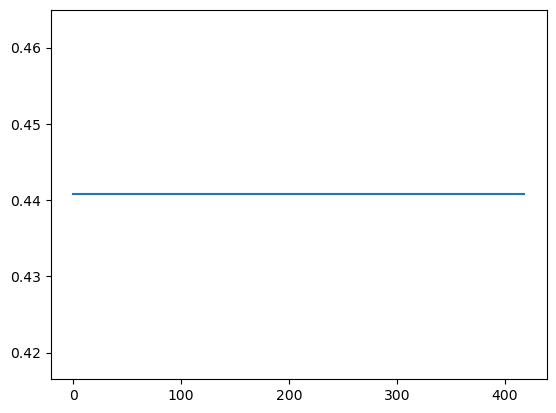

In [97]:
rolling_length = 5

autoencoder_losses_moving_average = (
    np.convolve(
        np.array(autoencoder_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)

plt.plot(autoencoder_losses_moving_average)

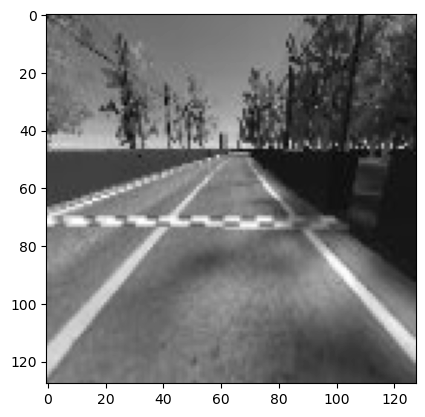

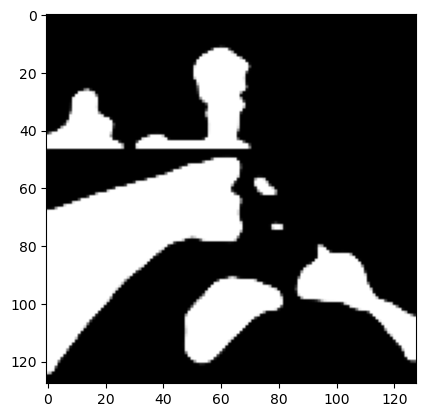

In [83]:
""" show the observation """
plt.imshow(torch.permute(batch_tensor[0].cpu(), (1,2,0)), cmap="gray")
plt.show()

""" show the reconstruction """
autoencoder.eval()
with torch.no_grad():
    plt.imshow(torch.permute(autoencoder(batch_tensor)[0].cpu(), (1,2,0)), cmap="gray")
    plt.show()
autoencoder.train();

In [85]:
""" latent space exploration """

n_sliders = 32
latent_range = (0, 1, 0.01)

ae2 = Autoencoder(greyscale=True).to(device)
ae2.load_weights("AE")

slider_args = {}
for i in range(n_sliders):
    slider_args[f"x{i+1}"] = latent_range
    
@widgets.interact(**slider_args)
def f(**kwargs):
    
    slider_values = [
        kwargs[f"x{i+1}"] for i in range(n_sliders)]
    
    h = torch.tensor(slider_values, device=device).view(1,2,4,4)
    with torch.no_grad():
        plt.imshow(torch.permute(ae2.decoder(h)[0].cpu(), (1,2,0)), cmap="gray")

Set AE to evaluation mode.


interactive(children=(FloatSlider(value=0.0, description='x1', max=1.0, step=0.01), FloatSlider(value=0.0, des…

In [ ]:
autoencoder.encoder(batch_tensor)[0].shape

In [ ]:
losses=[]

# get a loss and update the autoencoder
x = transform(obs) # [3, 64, 64]
x = x[None, :] # B=1 -> [1, 3, 64, 64]
    
for i in range(500):
    
    xhat = autoencoder(x)
    
    autoencoder_loss = autoencoder_criterion(x, xhat)
    autoencoder_optim.zero_grad()
    autoencoder_loss.backward()
    autoencoder_optim.step()
    
    losses.append(autoencoder_loss.item())

In [ ]:
for param in autoencoder.parameters():
    print(param.grad)

In [ ]:
plt.plot(losses)

In [123]:
class VAE(nn.Module):
    def __init__(self, greyscale=True, beta=4):
        super(VAE, self).__init__()

        if greyscale:
            self.input_channels = 1
        else:
            self.input_channels = 3
            
        self.beta = 4 # kl-multiplier (from beta-VAE paper)
        
        self.encoder = nn.Sequential(
            ConvBlock(self.input_channels, 16),
            ResConvBlock(16, 16),
            ConvBlock(16, 16, kernel_size=4, padding=1, stride=2), #nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(16, 32),
            ResConvBlock(32, 32),
            ConvBlock(32, 32, kernel_size=4, padding=1, stride=2), #nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(32, 64),
            ResConvBlock(64, 64),
            ConvBlock(64, 64, kernel_size=4, padding=1, stride=2), #nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(64, 128),
            ResConvBlock(128, 128),
            ConvBlock(128, 128, kernel_size=4, padding=1, stride=2), #nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(128, 256),
            ResConvBlock(256, 256),
            ConvBlock(256, 256, kernel_size=4, padding=2, stride=2), #nn.MaxPool2d(kernel_size=2, stride=2),
            
            ResConvBlock(256, 256),
            # ConvBlock(256, 4, kernel_size=4, padding=1, stride=1),
            
            ### try linear (everything below is new and can be deleted)
            ConvBlock(256, 8, kernel_size=4, padding=1, stride=1),
            nn.Flatten(),
            
        )
        
        self.mu = nn.Linear(8*4*4, 32)
        self.log_var = nn.Linear(8*4*4, 32)

        self.decoder = nn.Sequential(
            TransposeConvBlock(2, 32),
            ResConvBlock(32, 32),
            
            TransposeConvBlock(32, 64),
            ResConvBlock(64, 64),
            
            TransposeConvBlock(64, 128),
            ResConvBlock(128, 128),
            
            TransposeConvBlock(128, 256),
            ResConvBlock(256, 256),
            
            TransposeConvBlock(256, 512),
            ResConvBlock(512, 512),
            
            ResConvBlock(512, 512),
            ConvBlock(512, 32),
            nn.Conv2d(32, self.input_channels, kernel_size=3, padding=1, stride=1),
            nn.Sigmoid()
        )

        
    def encode(self, x):
        # before:
        #h = self.encoder(x).view(8, 2, 32)
        # mu, log_var = h[:,0,:], h[:,1,:]
        
        # new:
        h = self.encoder(x)
        mu, log_var = self.mu(h), self.log_var(h)
        return mu, log_var
    
    def decode(self, z):
        x = self.decoder(z)
        return x
        
    def forward(self, x):
        # get the distribution of z
        mu, log_var = self.encode(x)
        
        # reparameterization
        std = torch.exp(log_var / 2)
        epsilon = torch.randn_like(log_var)
        
        # sample z
        z = mu + std * epsilon
        
        # reconstruct x
        xhat = self.decode(z.view(-1, 2, 4, 4))
        return xhat, mu, log_var

    def get_loss(self, x, xhat, mu, log_var):
        
        # image reconstruction loss
        reconstruction_loss = F.mse_loss(x, xhat, reduction='sum')
        
        # KL divergence between the latent distribution and the standard normal distribution
        std = torch.exp(log_var / 2)
        kl_divergence = -0.5 * torch.sum(1 + log_var - std.pow(2) - mu.pow(2))
        
        # total loss
        loss = reconstruction_loss + self.beta * kl_divergence
        return loss, reconstruction_loss, kl_divergence

    def save_weights(self):
        if not os.path.exists("weights"):
            os.mkdir("weights")
        torch.save(self.state_dict(), "weights/VAE")
    
    def load_weights(self, path="weights/VAE", eval_mode=True):
        self.load_state_dict(torch.load(path))
        if eval_mode:
            print("Set VAE to evaluation mode.")
            self.eval()
        
    def get_num_params(self):
        return sum(p.numel() for p in vae.parameters() if p.requires_grad)

vae = VAE(greyscale=True).to(device)

vae_optim = optim.Adam(
    vae.parameters(), 
    lr=3e-4, 
    weight_decay=1e-5 # l2 regularization
)

vae_scheduler = ReduceLROnPlateau(vae_optim, 'min')


print(vae.get_num_params())

16448393


In [73]:
batch_tensor_dummy = torch.rand(8, 1, 128, 128, device=device)

xhat, mu, log_var = vae(batch_tensor_dummy)
print("xhat:", xhat.shape)
print("mu, sigma:", mu.shape, log_var.shape)

xhat: torch.Size([8, 1, 128, 128])
mu, sigma: torch.Size([8, 32]) torch.Size([8, 32])


In [88]:
""" vae training loop """

# create the environment
toy_env = False
if toy_env:
    env = gym.make("CarRacing-v2", render_mode="rgb_array")
else:
    exe_path = "/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64"
    port = 9091
    config = {
        "exe_path" : exe_path, 
        "port" : port 
    }
    env = gym.make(
        "GymV21Environment-v0", 
        env_id="donkey-minimonaco-track-v0", # donkey-warehouse-v0 
        make_kwargs={
            "conf": config
        })

n_episodes = 10000
vae_losses, reconstruction_losses, kl_div_losses = [], [], []
vae.train()

for episode in tqdm(range(n_episodes)):
    
    # get the initial state
    obs, info = env.reset()
    
    # setup a minibatch of x's for training the autoencoder
    batch_size = 8
    batch_counter = 0
    x = transform(obs)
    batch_tensor = torch.empty((batch_size,) + x.shape, device=device) # B,C,H,W
    
    # play one episode
    done = False
    while not done:
             
        # add the new x to the batch
        batch_tensor[batch_counter] = transform(obs)
        batch_counter += 1
        
        if batch_counter % batch_size == 0:
            # reset the batch counter
            batch_counter = 0
            
            # autoencoder forward pass with a minibatch
            xhat, mu, log_var = vae(batch_tensor)

            # get a loss and update the autoencoder
            vae_loss, reconstruction_loss, kl_div = vae.get_loss(batch_tensor, xhat, mu, log_var)
            vae_optim.zero_grad()
            vae_loss.backward()
            vae_optim.step()

            vae_losses.append(vae_loss.item())
            reconstruction_losses.append(reconstruction_loss.item())
            kl_div_losses.append(kl_div.item())
            
        # choose and execute an action
        action = env.action_space.sample()
        next_obs, reward, terminated, truncated, info = env.step(action)        
        
        # print(next_obs)
        # env.render()
        
        done = terminated or truncated
        obs = next_obs
        
env.close()

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: max_cte 8.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: host localhost
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
donkey subprocess started
Found path: /home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64


INFO:gym_donkeycar.core.client:connecting to localhost:9091 
/home/till/.local/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


loading scene mini_monaco


INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!
 15%|████████████▎                                                                     | 1495/10000 [1:30:48<8:36:38,  3.64s/it]


KeyboardInterrupt: 

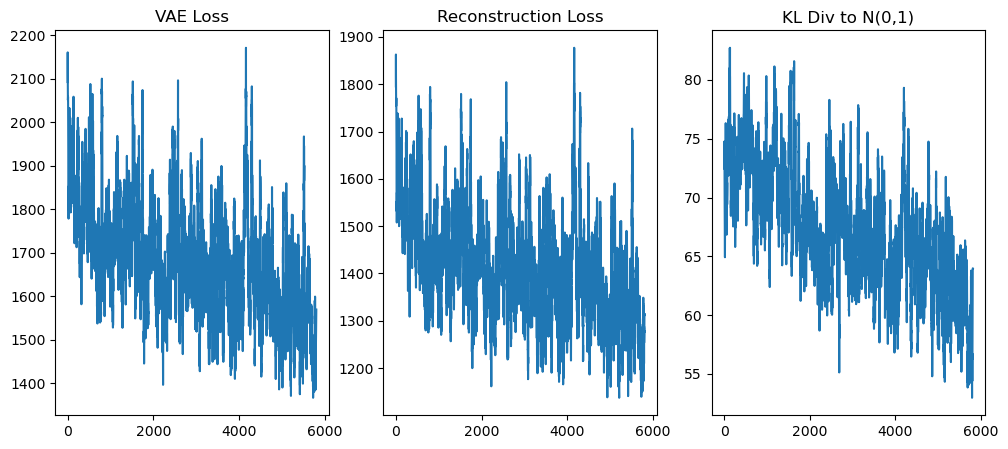

In [93]:
rolling_length = 20

fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

axs[0].set_title("VAE Loss")
vae_losses_moving_average = (
    np.convolve(
        np.array(vae_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(vae_losses_moving_average)), vae_losses_moving_average)


axs[1].set_title("Reconstruction Loss")
reconstruction_losses_moving_average = (
    np.convolve(
        np.array(reconstruction_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[1].plot(range(len(reconstruction_losses_moving_average)), reconstruction_losses_moving_average)

axs[2].set_title("KL Div to N(0,1)")
kl_div_losses_moving_average = (
    np.convolve(
        np.array(kl_div_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[2].plot(range(len(kl_div_losses_moving_average)), kl_div_losses_moving_average);

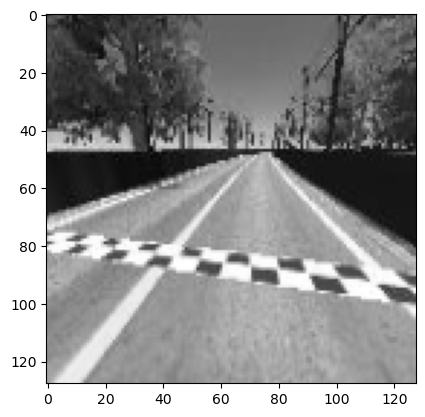

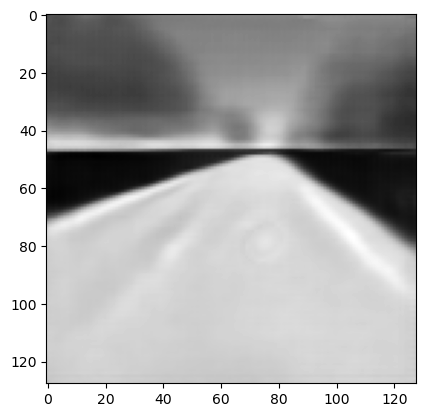

In [94]:
""" show the observation """
plt.imshow(torch.permute(batch_tensor[0].cpu(), (1,2,0)), cmap="gray")
plt.show()

""" show the reconstruction """
vae.eval()
with torch.no_grad():
    xhat, mu, log_var = vae(batch_tensor)
    plt.imshow(torch.permute(xhat[0].cpu(), (1,2,0)), cmap="gray")
    plt.show()
vae.train();

In [124]:
""" latent space exploration """

n_sliders = 32
latent_range = (0, 1, 0.01)

vae2 = VAE(greyscale=True).to(device)
vae2.load_weights()

slider_args = {}
for i in range(n_sliders):
    slider_args[f"z {i+1}"] = latent_range
    
@widgets.interact(**slider_args)
def f(**kwargs):
    
    slider_values = [
        kwargs[f"z {i+1}"] for i in range(n_sliders)]
    
    h = torch.tensor(slider_values, device=device).view(1,2,4,4)
    with torch.no_grad():
        plt.imshow(torch.permute(vae2.decoder(h)[0].cpu(), (1,2,0)), cmap="gray")

Set VAE to evaluation mode.


interactive(children=(FloatSlider(value=0.0, description='z 1', max=1.0, step=0.01), FloatSlider(value=0.0, de…

In [18]:
# from torchview import draw_graph
# import graphviz
# graphviz.set_jupyter_format('png')
# model_graph = draw_graph(
#     vae, 
#     input_size=(1,1,128,128), 
#     expand_nested=False,
#     hide_inner_tensors=True,
# )
# 
# model_graph.visual_graph